<a href="https://colab.research.google.com/github/Edgar-La/Intro_to_Natural_Language_Processing/blob/main/Project1/TM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bird, Steven, Edward Loper and Ewan Klein (2009), Natural Language Processing with Python. O’Reilly Media Inc.

# Descargar el archivo a analizar

In [1]:
!gdown --id 1A0ijJSvPRO3DPX_O50dsmq4EsEWaDGxc

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1A0ijJSvPRO3DPX_O50dsmq4EsEWaDGxc
To: /content/Datasets - Comments.xlsx
100% 81.5k/81.5k [00:00<00:00, 47.1MB/s]


# Importar paquetes

## Pre-procesamiento

In [42]:
import pandas as pd
import numpy as np
!pip install langdetect
!pip install iso-639
from langdetect import detect, DetectorFactory
from iso639 import languages
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import string
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as skl
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Se guarda la hoja de excel como dataframe

In [3]:
df = pd.read_excel('Datasets - Comments.xlsx', sheet_name = 'TripAdvisor')
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,NaN,NaN,NaN,NaN,NaN,Rango de fecha de comentarios,NaN,NaN,2015 - 2021,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,No,Name (click to view profile),Crítico de nivel,City,Profile ID,Date,Likes,Comment,View Source
3,NaN,1,Cipriano N,2,Orizaba,-,23 de marzo de 2016,NaN,El lugar es genial para comer hasta que te dej...,NaN
4,NaN,2,Oaxacalife,3,Orizaba,NaN,5 de junio de 2016,NaN,Limpio y bien diseñado. Bebidas y maravillosa ...,NaN


### Hay columnas que parecen sospechosas, lucen vacias entonces verificamos que en efecto lo sean

In [4]:
print(df['Unnamed: 0'].unique())
print(df['Unnamed: 5'].unique())
print(df['Unnamed: 7'].unique())
print(df['Unnamed: 9'].unique())
#print(df['Unnamed: 10'].unique())
#print(df['Unnamed: 11'].unique())
#print(df['Unnamed: 12'].unique())

[nan]
['Rango de fecha de comentarios' nan 'Profile ID' '-']
[nan 'Likes']
[nan 'View Source']


### Eliminamos esas columnas

In [5]:
df.drop(columns = ['Unnamed: 0',
                   'Unnamed: 1',
                   'Unnamed: 5',
                   'Unnamed: 7',
                   'Unnamed: 9',
                   #'Unnamed: 10',
                   #'Unnamed: 11',
                   #'Unnamed: 12'
                   ],
                   axis = 1, inplace = True)
df.head()

,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 6,Unnamed: 8
0,NaN,NaN,NaN,NaN,2015 - 2021
1,NaN,NaN,NaN,NaN,NaN
2,Name (click to view profile),Crítico de nivel,City,Date,Comment
3,Cipriano N,2,Orizaba,23 de marzo de 2016,El lugar es genial para comer hasta que te dej...
4,Oaxacalife,3,Orizaba,5 de junio de 2016,Limpio y bien diseñado. Bebidas y maravillosa ...


### Hay una fila (la segunda) que contiene el nombre las columnas, la obtenemos porque vamos a renombrar las columnas

In [6]:
columnas = df[df.columns].values[2]
columnas

array(['Name (click to view profile)', 'Crítico de nivel', 'City', 'Date',
       'Comment'], dtype=object)

### Eliminamos las filas que no contienen información importante y que eran parte del excel

In [7]:
df.drop([0,1,2], axis=0, inplace=True)
df.head()

,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 6,Unnamed: 8
3,Cipriano N,2,Orizaba,23 de marzo de 2016,El lugar es genial para comer hasta que te dej...
4,Oaxacalife,3,Orizaba,5 de junio de 2016,Limpio y bien diseñado. Bebidas y maravillosa ...
5,AugustoLara,2,Orizaba,3 de febrero 2017,"Muy buen restaurante de carnes, no dude en ped..."
6,GABINO M,4,Orizaba,24 de mayo de 2017,Este es un lugar donde se puede comer los taco...
7,MALH2001,-,Orizaba,15 de junio de 2017,"La comida era deliciosa, me comí una hamburgue..."


### Eliminamos el nombre de las columnas (para poder reasignar el nombre correcto)

In [8]:
df.columns = [''] * len(df.columns)
df.head()

,,,,,
3,Cipriano N,2,Orizaba,23 de marzo de 2016,El lugar es genial para comer hasta que te dej...
4,Oaxacalife,3,Orizaba,5 de junio de 2016,Limpio y bien diseñado. Bebidas y maravillosa ...
5,AugustoLara,2,Orizaba,3 de febrero 2017,"Muy buen restaurante de carnes, no dude en ped..."
6,GABINO M,4,Orizaba,24 de mayo de 2017,Este es un lugar donde se puede comer los taco...
7,MALH2001,-,Orizaba,15 de junio de 2017,"La comida era deliciosa, me comí una hamburgue..."


### Reasignamos los nombres correctos a las columnas

In [9]:
df.columns = columnas
df.rename(columns = {'Name (click to view profile)':'Name'}, inplace = True)
df.head()

,Name,Crítico de nivel,City,Date,Comment
3,Cipriano N,2,Orizaba,23 de marzo de 2016,El lugar es genial para comer hasta que te dej...
4,Oaxacalife,3,Orizaba,5 de junio de 2016,Limpio y bien diseñado. Bebidas y maravillosa ...
5,AugustoLara,2,Orizaba,3 de febrero 2017,"Muy buen restaurante de carnes, no dude en ped..."
6,GABINO M,4,Orizaba,24 de mayo de 2017,Este es un lugar donde se puede comer los taco...
7,MALH2001,-,Orizaba,15 de junio de 2017,"La comida era deliciosa, me comí una hamburgue..."


### Por ultimo, reseteamos el indice del dataframe

In [10]:
df.reset_index(inplace = True)
df.drop(columns = ['index'], axis=1, inplace=True)
df

,Name,Crítico de nivel,City,Date,Comment
0,Cipriano N,2,Orizaba,23 de marzo de 2016,El lugar es genial para comer hasta que te dej...
1,Oaxacalife,3,Orizaba,5 de junio de 2016,Limpio y bien diseñado. Bebidas y maravillosa ...
2,AugustoLara,2,Orizaba,3 de febrero 2017,"Muy buen restaurante de carnes, no dude en ped..."
3,GABINO M,4,Orizaba,24 de mayo de 2017,Este es un lugar donde se puede comer los taco...
4,MALH2001,-,Orizaba,15 de junio de 2017,"La comida era deliciosa, me comí una hamburgue..."
...,...,...,...,...,...
150,NormanT708,4,Orizaba,29 de diciembre de 2019,I had previously reviewed other Madison grill ...
151,cortegas72,4,Orizaba,16 de diciembre de 2020,Great restaurant to have a pleasant time with ...
152,Pablo R,3,Orizaba,24 de enero de 2016,Das Restaurant ist sehr schön an einem Platz g...
153,Xavigrand,4,Orizaba,18 de julio de 2018,"Si vous êtes un fana de viandes, ce restaurant..."


In [ ]:
#df.to_csv('Datasets - Comments - cleaned.csv', encoding = 'utf-16')

In [ ]:
#df.to_csv('Datasets - Comments - cleaned2.csv')

# NLP

### Creamos un nueva columna en el dataframe que indica el idioma del comentario

In [11]:
DetectorFactory.seed = 0
Language = []
for c in df['Comment']:
    Language.append(languages.get(alpha2 = detect(c)).name.lower())

In [12]:
df['Language'] = Language
df

,Name,Crítico de nivel,City,Date,Comment,Language
0,Cipriano N,2,Orizaba,23 de marzo de 2016,El lugar es genial para comer hasta que te dej...,spanish
1,Oaxacalife,3,Orizaba,5 de junio de 2016,Limpio y bien diseñado. Bebidas y maravillosa ...,spanish
2,AugustoLara,2,Orizaba,3 de febrero 2017,"Muy buen restaurante de carnes, no dude en ped...",spanish
3,GABINO M,4,Orizaba,24 de mayo de 2017,Este es un lugar donde se puede comer los taco...,spanish
4,MALH2001,-,Orizaba,15 de junio de 2017,"La comida era deliciosa, me comí una hamburgue...",spanish
...,...,...,...,...,...,...
150,NormanT708,4,Orizaba,29 de diciembre de 2019,I had previously reviewed other Madison grill ...,english
151,cortegas72,4,Orizaba,16 de diciembre de 2020,Great restaurant to have a pleasant time with ...,english
152,Pablo R,3,Orizaba,24 de enero de 2016,Das Restaurant ist sehr schön an einem Platz g...,german
153,Xavigrand,4,Orizaba,18 de julio de 2018,"Si vous êtes un fana de viandes, ce restaurant...",french


### Mostramos todos los idiomas en los que estan escritos los comentarios

In [13]:
unique_values_language = df['Language'].unique()
unique_values_language

array(['spanish', 'swedish', 'english', 'german', 'french', 'italian'],
      dtype=object)

### Para no repetir las stopwords 155 veces, hacemos un diccionario con los valores unicos

In [14]:
language_stopwords = {}
for L in unique_values_language:
    language_stopwords[L] = set(stopwords.words(L))

### Encontramos un comentario particular, este puede causar ruido en un futuro

In [15]:
indice = df.Language[df.Language == 'swedish'].index.tolist()
comentario1 = df['Comment'][indice]
comentario1

86    Bueno es un medio buen restaurantehrjrnrngncnñ...
Name: Comment, dtype: object

### C/u de los comentarios son tokenizados. Ademas se quitan mayusculas, signos de puntuacion, stopwords, emojis y numeros

In [16]:
vector_comments_tokenized = []
for i in range(len(df)):
    comment = df['Comment'][i].lower()    #ponemos en minusculas el comentario
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    comment = tokenizer.tokenize(comment.lower()) #eliminamos signos de puntuacion
    comment = ' '.join(comment)    #el vector resultante lo hacemos string de nuevo

    words_tokenized = word_tokenize(comment)
    stop_words = language_stopwords[df['Language'][i]] #Al diccionario que hicimos le indicamos el idioma y nos da las stopwords
    
    filtered_sentence = [w for w in words_tokenized if not w in stop_words] #Filtramnos y obtenemos el comentario tokenizado
    filtered_sentence = ([i for i in filtered_sentence if not i.isdigit()]) #Quitamos numeros
    vector_comments_tokenized.append(filtered_sentence) #Se repite para todos los comentarios, por eso se guardan en un vector

### Verificamos que funcione

In [17]:
i = 123
#i = 27
df['Comment'][i], vector_comments_tokenized[i]

('Pésimo servicio por parte de los meseros, teníamos altas expectativas, pedí 5 hamburguesas fueron $600.00 las hamburguesas sin sabor, sin sal ni la carne ni las papas, la verdad una porquería, no me quisieron dar catsup, ni salsa, ni chile, nada,, pésimo servicio, jamas volvería..creo que la capacitación del personal es deficiente, el área de recursos humanos debe acercarse al personal y orientarlos en el trato a los clientes.',
 ['pésimo',
  'servicio',
  'parte',
  'meseros',
  'altas',
  'expectativas',
  'pedí',
  'hamburguesas',
  'hamburguesas',
  'sabor',
  'sal',
  'carne',
  'papas',
  'verdad',
  'porquería',
  'quisieron',
  'dar',
  'catsup',
  'salsa',
  'chile',
  'pésimo',
  'servicio',
  'jamas',
  'volvería',
  'creo',
  'capacitación',
  'personal',
  'deficiente',
  'área',
  'recursos',
  'humanos',
  'debe',
  'acercarse',
  'personal',
  'orientarlos',
  'trato',
  'clientes'])

## Frequent Itemset Matrix

In [18]:
# Todos los tokens de todos los comentarios ya filtrados los pasamos a un solo vector
vector_comments_tokenized_flatten = [token for comment in vector_comments_tokenized for token in comment]
# Ese vector lo reducimos a que solo contenga valores unicos
vector_comments_tokenized_flatten = list(set(vector_comments_tokenized_flatten))
vector_comments_tokenized_flatten

['capacitado',
 'correcto',
 'slow',
 'guadalupe',
 'compro',
 'pastor',
 'nachos',
 'puedes',
 'excellent',
 'parmi',
 'visitas',
 'légumes',
 'scrive',
 'conozco',
 'fumadores',
 'gustan',
 'bloody',
 'recipient',
 'tostones',
 'llegara',
 'preguntar',
 'decide',
 'maravilla',
 'fría',
 'compare',
 'días',
 'extras',
 'brasas',
 'tomar',
 'pasar',
 'bonito',
 'unas',
 'cualquier',
 'exótica',
 'mezcal',
 'créeme',
 'secas',
 'gin',
 'ofertas',
 'nivel',
 'piso',
 'nonetheless',
 'deficiente',
 'desesperado',
 'presentations',
 'negocios',
 'everything',
 'sink',
 'concurrido',
 'amantes',
 'contemporary',
 'atiendan',
 'bonitas',
 'restroom',
 'buen',
 'fresca',
 'giusseppe',
 'decoracion',
 'excelentes',
 'frijoles',
 'córdoba',
 'choix',
 'familia',
 'sentir',
 'expectativas',
 'van',
 'ferrero',
 'razonables',
 'better',
 'azul',
 'comensales',
 'estilo',
 'terrible',
 'sopa',
 'particular',
 'buscas',
 'ruedas',
 'términos',
 'give',
 'realizarlo',
 'empalagosa',
 'scanear',
 'gu

Podemos ver que la matriz sera de:

In [19]:
#Renglones y columnas:
print(len(df), len(vector_comments_tokenized_flatten))

155 1492


In [20]:
frequent_Itemset_Matrix = []
for comment in vector_comments_tokenized:
    count_vector = []
    for item in vector_comments_tokenized_flatten:
        count = 0
        for token in comment:
            if item == token:
                count += 1
        count_vector.append(count)
    frequent_Itemset_Matrix.append(count_vector)
frequent_Itemset_Matrix = np.array(frequent_Itemset_Matrix)
frequent_Itemset_Matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [21]:
np.shape(frequent_Itemset_Matrix)

(155, 1492)

# Clustering

## Creamos el modelo y lo entrenamos

In [22]:
kmeans = KMeans(init='k-means++', n_clusters = 3)
kmeans.fit(frequent_Itemset_Matrix)
y_kmeans = kmeans.predict(frequent_Itemset_Matrix)
centers = kmeans.cluster_centers_

## Obtenemos los centros de los 3 clusters

In [23]:
centers

array([[ 4.33680869e-18,  2.94117647e-02,  4.33680869e-18, ...,
         2.94117647e-02,  2.94117647e-02,  4.33680869e-18],
       [ 8.33333333e-03, -8.67361738e-18,  8.33333333e-03, ...,
        -8.67361738e-18, -8.67361738e-18,  8.33333333e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## Obtenemos las etiquetas que el metodo asigno
(en clustering estas etiquetas son desconocidas, por lo que no sabemos el tipo de comentario aun)

In [24]:
y_kmeans

array([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1], dtype=int32)

# __Utilizamos clasificación por maquinas de soporte vectorial__

## Entrenamos con la matriz de frecuencias y las etiquetas resultantes y predecimos con la SVM creada.

In [36]:
svc = SVC(gamma = 0.1, C = 10)
svc.fit(frequent_Itemset_Matrix, y_kmeans)
y_predict_svm = svc.predict(frequent_Itemset_Matrix)
y_predict_svm

array([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1], dtype=int32)

## Calculamos la matriz de confusión

In [37]:
confusion_matrix = skl.confusion_matrix(y_kmeans, y_predict_svm)
confusion_matrix

array([[ 34,   0,   0],
       [  0, 120,   0],
       [  0,   0,   1]])

## Hacemos la matriz de confusión más estética

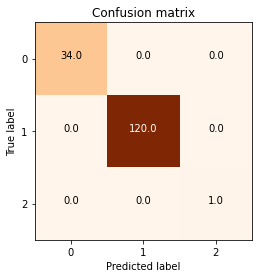

In [34]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(confusion_matrix)

## A partir de la matriz de confusión calculamos métricas de rendimiento de la máquina SVM

In [33]:
diag = 0
for i in range(len(confusion_matrix)):
  diag += confusion_matrix[i][i]
ACC = diag/len(y_kmeans)
ACC

1.0

In [53]:
f1_score(y_kmeans, y_predict_svm, average='macro')

1.0

In [54]:
f1_score(y_kmeans, y_predict_svm, average='micro')

1.0

In [57]:
f1_score(y_kmeans, y_predict_svm, average='weighted')

1.0

In [58]:
f1_score(y_kmeans, y_predict_svm, average=None)

array([1., 1., 1.])

# __Utilizamos clasificación por el método de Naive Bayes__

In [38]:
gnb = GaussianNB()
gnb.fit(frequent_Itemset_Matrix, y_kmeans)
y_predict_nb = gnb.predict(frequent_Itemset_Matrix)
y_predict_nb

array([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1], dtype=int32)

## Repetimos la metodología de la matriz de confusión para obtener las métricas de Naive Bayes

In [43]:
confusion_matrix = skl.confusion_matrix(y_kmeans, y_predict_nb)
confusion_matrix

array([[ 34,   0,   0],
       [  1, 119,   0],
       [  0,   0,   1]])

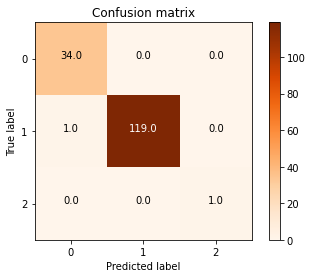

In [59]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(confusion_matrix)

In [45]:
diag = 0
for i in range(len(confusion_matrix)):
  diag += confusion_matrix[i][i]
ACC = diag/len(y_kmeans)
ACC

0.9935483870967742

In [48]:
f1_score(y_kmeans, y_predict_nb, average='macro')

0.9937743819861339

In [50]:
f1_score(y_kmeans, y_predict_nb, average='micro')

0.9935483870967742

In [51]:
f1_score(y_kmeans, y_predict_nb, average='weighted')

0.9935816408167897

In [52]:
f1_score(y_kmeans, y_predict_nb, average=None)

array([0.98550725, 0.9958159 , 1.        ])